### Autoencoder for binary classification

In this notebook, I will experiment with the implementation of an autoencoder for binary classification of the histopathology dataset. First, the required libraries are imported and the size of the images in the PCAM dataset is defined.

In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

### Instantiating data generators

The PatchCAMELYON dataset is too big to fit in the working memory of most personal computers. This is why, we need to define some functions that will read the image data batch by batch, so only a single batch of images needs to be stored in memory at one time point. We can use the handy ImageDataGenerator function from the Keras API to do this. Note that the generators are defined within a function that returns them as output arguments. This function will later be called from the main code body. 


In [76]:
def get_pcam_generators(base_dir, train_batch_size=16, val_batch_size=16):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='input')

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='input',
                                             shuffle=False)
     
     return train_gen, val_gen

### Building an autoencoder model

The autoencoder neural network model is also defined within a function. Organizing the code into functions instead of piling everything up in a single script makes the code more clear to read and understand, and helps reuse functionality that is already implemented. For example, we can use the `get_pcam_generators()` function to create data generators with different batch sizes just by calling the function with a different set of parameters. Or, we can use the `get_model()` function to generate networks with different number of feature maps (see below). 

In [77]:
def get_autoencoder(kernel_size=(3,3), pool_size=(2,2), first_filters=32, second_filters=16):


     # build the enoder: standard latent representation of (12,12,16)
     model = Sequential()

     # encoder: standard latent representation of (12,12,16)
     model.add(Conv2D(first_filters, kernel_size, activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
     model.add(MaxPool2D(pool_size))
     model.add(Conv2D(second_filters, kernel_size, activation='relu', padding='same'))
     model.add(MaxPool2D(pool_size))

     # decoder: upsampling to reconstruct input
     model.add(Conv2D(second_filters, kernel_size, activation='relu', padding='same'))
     model.add(UpSampling2D(pool_size))
     model.add(Conv2D(first_filters, kernel_size, activation='relu', padding='same'))
     model.add(UpSampling2D(pool_size))

     # reconstructing image: (96,96,1)
     model.add(Conv2D(3, kernel_size, activation='sigmoid', padding='same'))
    
     # compile the model
     model.compile(Adam(learning_rate=0.001), loss='mean_squared_error')

     return model

Now, the two functions that define the model and the data generators can be called from the main code body. Before executing the code block below, do not forget to change the path where the PatchCAMELYON dataset is located (that is, the location of the folder that contains `train+val` that you previously downloaded and unpacked).

If everything is correct, the following output will be printed on screen after executing the code block:

`Found 144000 images belonging to 2 classes.`

`Found 16000 images belonging to 2 classes.`

In [78]:
# get the model
autoencoder = get_autoencoder()

# get the data generators
train_gen, val_gen = get_pcam_generators('../data')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


If you want to know the shapes of the outputs of all layers in the network (the dimensionality of the feature maps), you can print them in the following way:

In [79]:
autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 16)        2320      
                                                                 
 up_sampling2d_6 (UpSamplin  (None, 48, 48, 16)       

### Training and evaluating the model

Finally, the model can be trained using data generated by the data generators and then evaluated. This is done in a similar way to the previous assignment. Furthermore, in addition to the Tensorflow callback, an additional callback that saves the "best" version of the trained model to a file is added, and the model structure is saved to a json file. This enables loading the model and corresponding weights at a later time point (e.g. when we want to evaluate the model on a test set). 

In [80]:
# save the model and weights
model_name = 'first_autoencoder'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = autoencoder.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size//4
val_steps = val_gen.n//val_gen.batch_size//4

history = autoencoder.fit(train_gen, steps_per_epoch=train_steps, 
                          validation_data=val_gen,
                          validation_steps=val_steps,
                          epochs=3,
                          callbacks=callbacks_list)

Epoch 1/3
2250/2250 [==============================] - ETA: 0s - loss: 0.0149
Epoch 1: val_loss improved from inf to 0.01208, saving model to first_autoencoder_weights.hdf5
2250/2250 [==============================] - 595s 264ms/step - loss: 0.0149 - val_loss: 0.0121
Epoch 2/3


c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2250/2250 [==============================] - ETA: 0s - loss: 0.0109
Epoch 2: val_loss improved from 0.01208 to 0.01074, saving model to first_autoencoder_weights.hdf5
2250/2250 [==============================] - 446s 198ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 3/3
2250/2250 [==============================] - ETA: 0s - loss: 0.0100
Epoch 3: val_loss improved from 0.01074 to 0.00996, saving model to first_autoencoder_weights.hdf5
2250/2250 [==============================] - 416s 185ms/step - loss: 0.0100 - val_loss: 0.0100


1/1 [==============================] - 0s 56ms/step


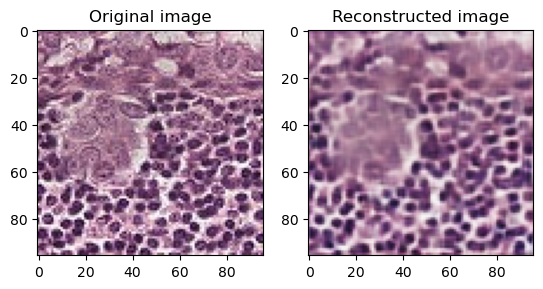

In [87]:
# Produce a prediction on the validation set
img_batch = train_gen[0][0]
predict_test = autoencoder.predict(img_batch) # [batch][class][image_nr]
image_nr = 3

fig,ax = plt.subplots(1,2)
ax[0].imshow(img_batch[image_nr])
ax[0].set_title('Original image')
ax[1].imshow(predict_test[image_nr])
ax[1].set_title('Reconstructed image');